In [ ]:
# Utilizes code from:
# https://github.com/VSainteuf/utae-paps
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb

In [1]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = 'C:/Users/blake/OneDrive/Desktop/Computer Vision/Project/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = 'D:/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)

# import the necessary packages
import torch
import torch.nn as nn
import torch.utils.data as data

import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib


cm = matplotlib.colormaps.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [2]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=100, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [3]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3

In [4]:
import evaluate

metric = evaluate.load("mean_iou")

In [5]:
import os 

def save_results(fold, metrics):
    if isinstance(metrics, torch.Tensor):
        metrics = metrics.cpu().numpy()
    with open(
        os.path.join('output', "Fold_{}".format(fold), "test_metrics.json"), "w"
    ) as outfile:
        json.dump(metrics, outfile, indent=4)

In [7]:
from sklearn.metrics import accuracy_score

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

fold_sequence = [
    [[3, 4, 5], [1], [2]],
]

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0')
batch_size = 150

In [6]:
for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    # Dataset definition
    dt_args = dict(
        folder='D:/PASTIS',
        norm=True,
        target="semantic",
        sats=["S2"],
    )

    dt_train = PASTIS_Dataset(**dt_args, folds=train_folds)
    dt_val = PASTIS_Dataset(**dt_args, folds=val_fold)
    dt_test = PASTIS_Dataset(**dt_args, folds=test_fold)

    collate_fn = pad_collate
    train_loader = data.DataLoader(
        dt_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    val_loader = data.DataLoader(
        dt_val,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    test_loader = data.DataLoader(
        dt_test,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

    print(
        "Train {}, Val {}, Test {}".format(len(dt_train), len(dt_val), len(dt_test))
    )

    # Training loop
    trainlog = {}
    best_mIoU = 0

    model.train()
    for epoch in range(100):  # loop over the dataset multiple times
        print("Epoch:", epoch)
        for idx, batch in enumerate(train_loader):
            # get the inputs;
            (x, dates), y = batch
            y = y.long().to(device)
            x = x['S2'][:, 0, range(0,3), :, :].to(device)
            pixel_values = x
            labels = y

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            loss.backward()
            optimizer.step()

            # evaluate
            with torch.no_grad():
              upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
              predicted = upsampled_logits.argmax(dim=1)

              # note that the metric expects predictions + labels as numpy arrays
              metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

            # let's print loss and metrics every 2 batches
            if idx % 2 == 0:
              # currently using _compute instead of compute
              # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
              metrics = metric._compute(
                      predictions=predicted.cpu(),
                      references=labels.cpu(),
                      num_labels=20,
                      ignore_index=255,
                      reduce_labels=False, # we've already reduced the labels ourselves
                  )

              print("Loss:", loss.item())
              print("Mean_iou:", metrics["mean_iou"])
              print("Mean accuracy:", metrics["mean_accuracy"])
        
        torch.save(
            {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            os.path.join(
                'output', "Fold_{}".format(fold + 1), "model2.pth.tar"
            ),
        )


Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Train 1452, Val 487, Test 494
Epoch: 0


c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 4.910016059875488
Mean_iou: 0.00657585021946819
Mean accuracy: 0.007661268636936345
Loss: 4.840742588043213
Mean_iou: 0.011844722707772934
Mean accuracy: 0.01459572607307726
Loss: 4.784483909606934
Mean_iou: 0.019232935310088288
Mean accuracy: 0.028214701638912282
Loss: 4.728703022003174
Mean_iou: 0.029711275759570322
Mean accuracy: 0.03904108117071263
Loss: 4.678995132446289
Mean_iou: 0.03210136890169118
Mean accuracy: 0.04365010469165061
Epoch: 1
Loss: 4.652054786682129
Mean_iou: 0.03810811928698178
Mean accuracy: 0.055578784654010616
Loss: 4.579974174499512
Mean_iou: 0.039807358388949485
Mean accuracy: 0.05767594387190204
Loss: 4.487982749938965
Mean_iou: 0.04703029128015954
Mean accuracy: 0.07399404159757404
Loss: 4.428210258483887
Mean_iou: 0.04886566541309778
Mean accuracy: 0.07942352384851735
Loss: 4.4054975509643555
Mean_iou: 0.0471229027006584
Mean accuracy: 0.07813383383990383
Epoch: 2
Loss: 4.367166996002197
Mean_iou: 0.04735786682488105
Mean accuracy: 0.08328366012103

In [7]:
model_final = model
'''
print("Testing best epoch . . .")
model.load_state_dict(
    torch.load(
        os.path.join(
            'output', "Fold_{}".format(fold + 1), "model2.pth.tar"
        )
    )["state_dict"]
)
'''

model_final.eval()
for idx, batch in enumerate(test_loader):
    # get the inputs;
    (x, dates), y = batch
    y = y.long().to(device)
    x = x['S2'][:, 0, range(0,3), :, :].to(device)
    pixel_values = x
    labels = y
    
    optimizer.zero_grad()
    outputs = model_final(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits

    # evaluate
    with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # let's print loss and metrics every 2 batches
    if idx % 2 == 0:
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
                predictions=predicted.cpu(),
                references=labels.cpu(),
                num_labels=20,
                ignore_index=255,
                reduce_labels=False, # we've already reduced the labels ourselves
            )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])



c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 1.6066664457321167
Mean_iou: 0.09543111773831578
Mean accuracy: 0.15122086738946872
Loss: 1.5156419277191162
Mean_iou: 0.09602796190528953
Mean accuracy: 0.14994116550783282


In [7]:
model.load_state_dict(
    torch.load(
        os.path.join(
            'output', "Fold_{}".format(1), "model_best.pth.tar"
        )
    )["state_dict"]
)

<All keys matched successfully>

In [8]:
metric_best = 0.11
for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    # Dataset definition
    dt_args = dict(
        folder='D:/PASTIS',
        norm=True,
        target="semantic",
        sats=["S2"],
    )

    dt_train = PASTIS_Dataset(**dt_args, folds=train_folds)
    dt_val = PASTIS_Dataset(**dt_args, folds=val_fold)
    dt_test = PASTIS_Dataset(**dt_args, folds=test_fold)

    collate_fn = pad_collate
    train_loader = data.DataLoader(
        dt_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    val_loader = data.DataLoader(
        dt_val,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    test_loader = data.DataLoader(
        dt_test,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

    print(
        "Train {}, Val {}, Test {}".format(len(dt_train), len(dt_val), len(dt_test))
    )

    # Training loop
    trainlog = {}
    best_mIoU = 0

    model.train()
    for epoch in range(50):  # loop over the dataset multiple times
        print("Epoch:", epoch)
        for idx, batch in enumerate(train_loader):
            # get the inputs;
            (x, dates), y = batch
            y = y.long().to(device)
            x = x['S2'][:, 0, range(0,3), :, :].to(device)
            pixel_values = x
            labels = y

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            loss.backward()
            optimizer.step()

            # evaluate
            with torch.no_grad():
              upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
              predicted = upsampled_logits.argmax(dim=1)

              # note that the metric expects predictions + labels as numpy arrays
              metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

            # let's print loss and metrics every 2 batches
            if idx % 2 == 0:
              # currently using _compute instead of compute
              # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
              metrics = metric._compute(
                      predictions=predicted.cpu(),
                      references=labels.cpu(),
                      num_labels=20,
                      ignore_index=255,
                      reduce_labels=False, # we've already reduced the labels ourselves
                  )

              print("Loss:", loss.item())
              print("Mean_iou:", metrics["mean_iou"])
              print("Mean accuracy:", metrics["mean_accuracy"])
        
        print("Saving training model")
        torch.save(
            {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            os.path.join(
                'output', "Fold_{}".format(1), "model_latest_epoch.pth.tar"
            ),
        )
        
        print("Validation:")
        inner_metrics = []
        model.eval()
        for idx, batch in enumerate(val_loader):
            # get the inputs;
            (x, dates), y = batch
            y = y.long().to(device)
            x = x['S2'][:, 0, range(0,3), :, :].to(device)
            pixel_values = x
            labels = y
            
            optimizer.zero_grad()
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            # evaluate
            with torch.no_grad():
                upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                # note that the metric expects predictions + labels as numpy arrays
                metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

            # currently using _compute instead of compute
            # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
            metrics = metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=20,
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
                )

            inner_metrics.append(metrics["mean_iou"])

        new_metric = np.mean(inner_metrics) 
        print("Mean_iou:", new_metric)

        if new_metric > metric_best:
            metric_best = new_metric
            print("Saving best model")
            torch.save(
                {
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                },
                os.path.join(
                    'output', "Fold_{}".format(fold + 1), "model_best.pth.tar"
                ),
            )

Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Train 1452, Val 487, Test 494
Epoch: 0


c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 1.1781917810440063
Mean_iou: 0.26235079477998985
Mean accuracy: 0.3487551166919386
Loss: 1.0821582078933716
Mean_iou: 0.2603934698170893
Mean accuracy: 0.34191296381450587
Loss: 1.1149804592132568
Mean_iou: 0.2325129342871996
Mean accuracy: 0.30331440422213884
Loss: 1.1389245986938477
Mean_iou: 0.22746310836282851
Mean accuracy: 0.30134172752481664
Loss: 1.093414545059204
Mean_iou: 0.2526790293088244
Mean accuracy: 0.33179270866179617
Saving training model
Validation:
Mean_iou: 0.11025978842241278
Saving best model
Epoch: 1
Loss: 1.020788311958313
Mean_iou: 0.30006246031278144
Mean accuracy: 0.3871059181412213
Loss: 0.9191136956214905
Mean_iou: 0.29543130326755274
Mean accuracy: 0.38668461812104743
Loss: 0.951869010925293
Mean_iou: 0.3031464537883186
Mean accuracy: 0.3912772533317121
Loss: 0.9566835761070251
Mean_iou: 0.28005431883031623
Mean accuracy: 0.3705685750387645
Loss: 0.9913304448127747
Mean_iou: 0.30743676251101315
Mean accuracy: 0.4051583547782493
Saving training model

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:49                                                                                   │
│                                                                                                  │
│    46 │   model.train()                                                                          │
│    47 │   for epoch in range(50):  # loop over the dataset multiple times                        │
│    48 │   │   print("Epoch:", epoch)                                                             │
│ ❱  49 │   │   for idx, batch in enumerate(train_loader):                                         │
│    50 │   │   │   # get the inputs;                                                              │
│    51 │   │   │   (x, dates), y = batch                                                          │
│    52 │   │   │   y = y.long().to(device)                                                        │
│                                                                                                  │
│ c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\datalo │
│ ader.py:633 in __next__                                                                          │
│                                                                                                  │
│    630 │   │   │   if self._sampler_iter is None:                                                │
│    631 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    632 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  633 │   │   │   data = self._next_data()                                                      │
│    634 │   │   │   self._num_yielded += 1                                                        │
│    635 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    636 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\datalo │
│ ader.py:677 in _next_data                                                                        │
│                                                                                                  │
│    674 │                                                                                         │
│    675 │   def _next_data(self):                                                                 │
│    676 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  677 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    678 │   │   if self._pin_memory:                                                              │
│    679 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    680 │   │   return data                                                                       │
│                                                                                                  │
│ c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils │
│ \fetch.py:51 in fetch                                                                            │
│                                                                                                  │
│   48 │   │   │   if hasattr(self.dataset, "__getitems__") and self.dataset.__getitems__:         │
│   49 │   │   │   │   data = self.dataset.__getitems__(possibly_batched_index)                    │
│   50 │   │   │   else:                                                                           │
│ ❱ 51 │   │   │   │   data = [self.dataset[idx] for idx in p

In [30]:
for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    dt_args = dict(
        folder='D:/PASTIS',
        norm=True,
        target="semantic",
        sats=["S2"],
    )

    dt_train = PASTIS_Dataset(**dt_args, folds=train_folds)
    dt_test = PASTIS_Dataset(**dt_args, folds=test_fold)

    collate_fn = pad_collate
    train_loader = data.DataLoader(
        dt_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.


In [12]:
model.load_state_dict(
    torch.load(
        os.path.join(
            'output', "Fold_{}".format(1), "model_latest_epoch.pth.tar"
        )
    )["state_dict"]
)

<All keys matched successfully>

In [15]:
from matplotlib import pyplot as plt

for idx, batch in enumerate(train_loader):
    break
# idx, batch = train_loader.__iter__().__next__()
(x, dates), y = batch

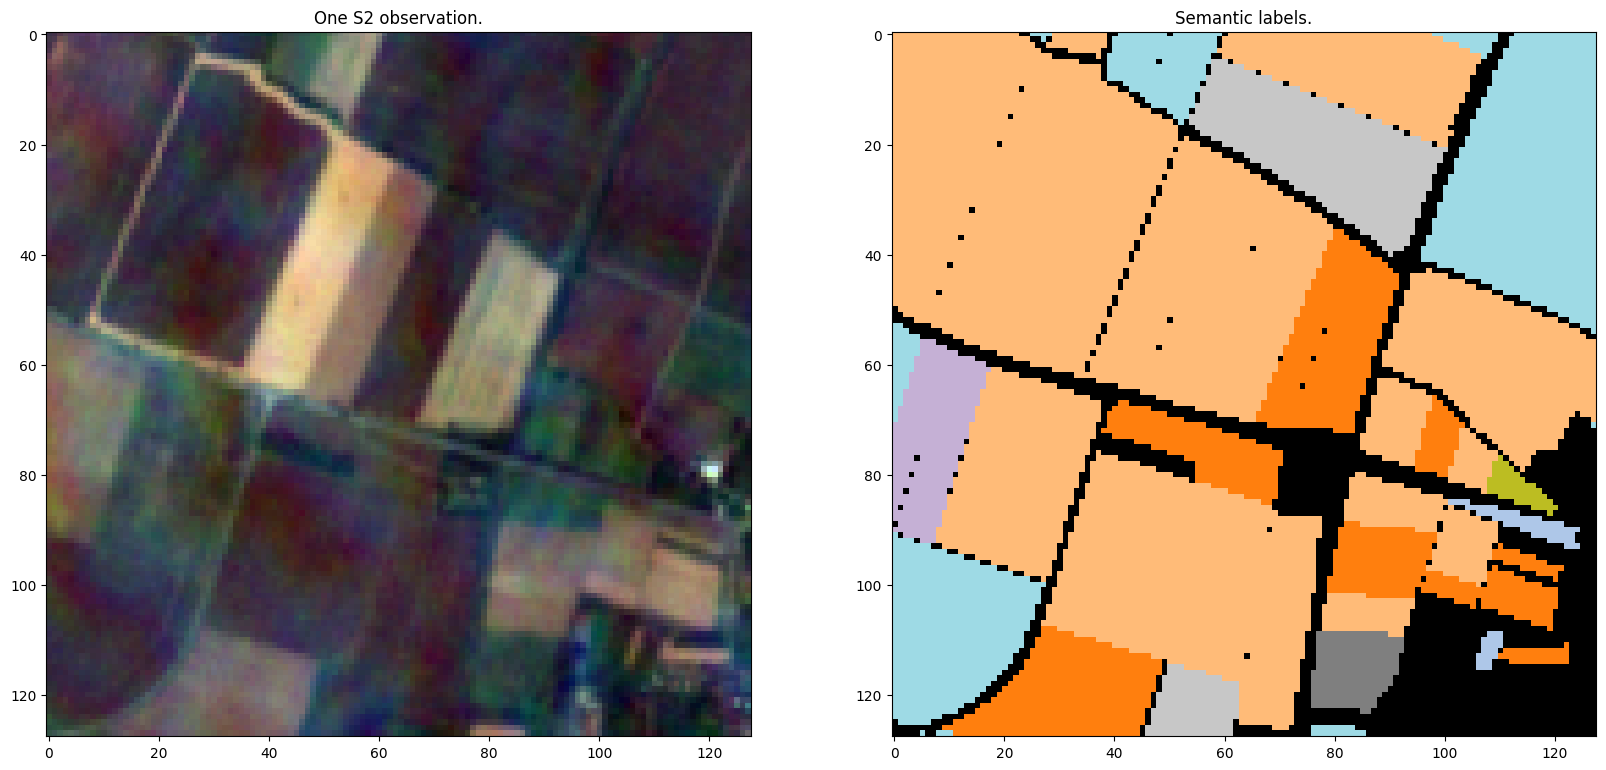

In [17]:
bid = 1 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

plt.show()

In [18]:
im = x['S2'][bid, 1, [2,1,0]].to(device)
im = im.resize(1, 3, 128, 128)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=im)

c:\Users\blake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [19]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 32, 32])


In [22]:
labels = y.long().to(device)

In [24]:
with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

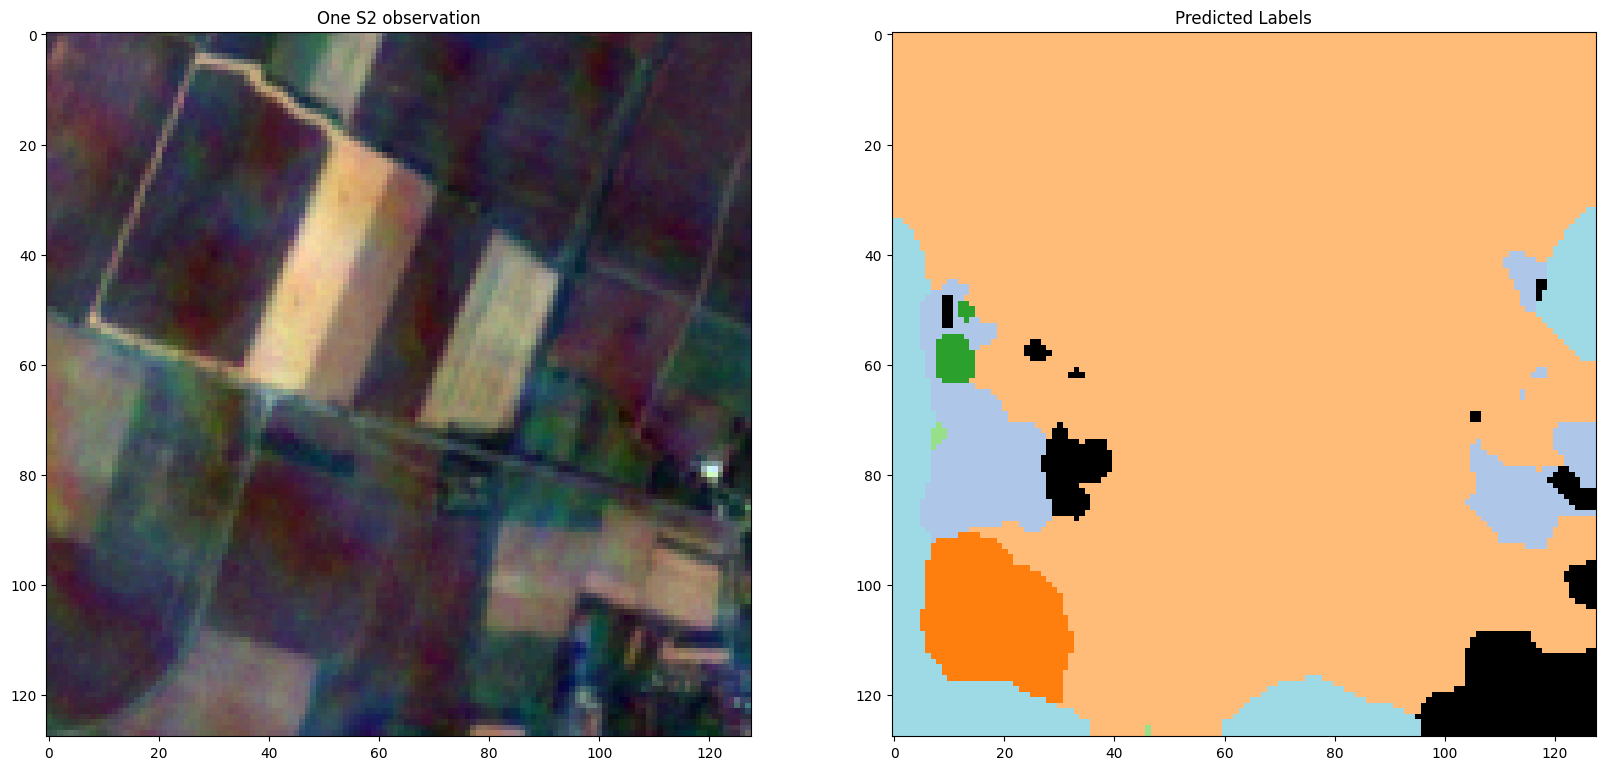

In [25]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(predicted.squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation')
axes[1].set_title('Predicted Labels')

plt.show()

In [31]:
test_loader = data.DataLoader(
    dt_test,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

In [32]:
for idx, batch in enumerate(test_loader):
    break

(x, dates), y = batch

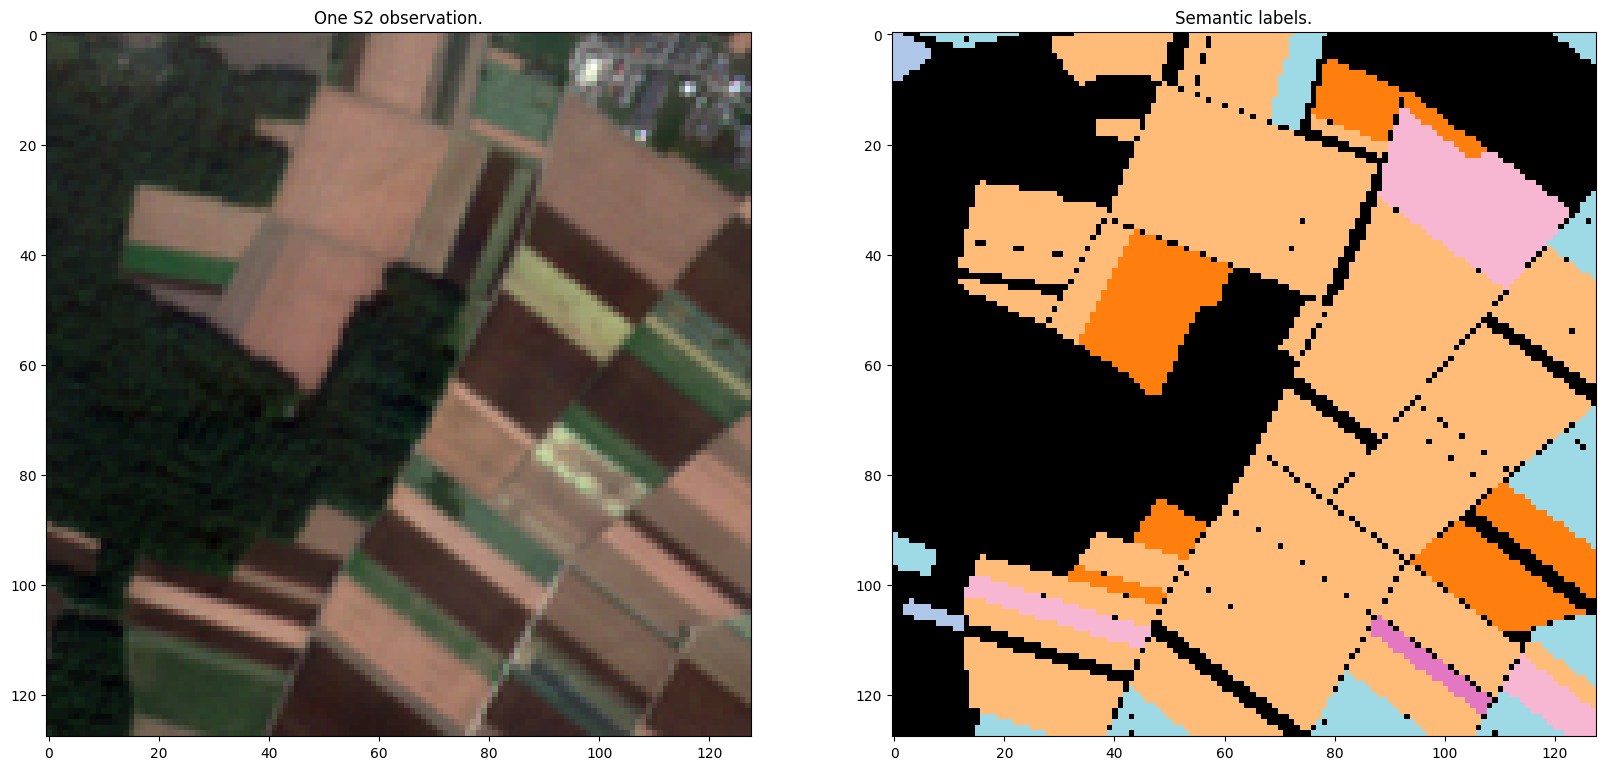

In [45]:
bid = 3 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

plt.show()

In [46]:
im = x['S2'][bid, 1, [2,1,0]].to(device)
im = im.resize(1, 3, 128, 128)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=im)

In [47]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 32, 32])


In [48]:
labels = y.long().to(device)

In [49]:
with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

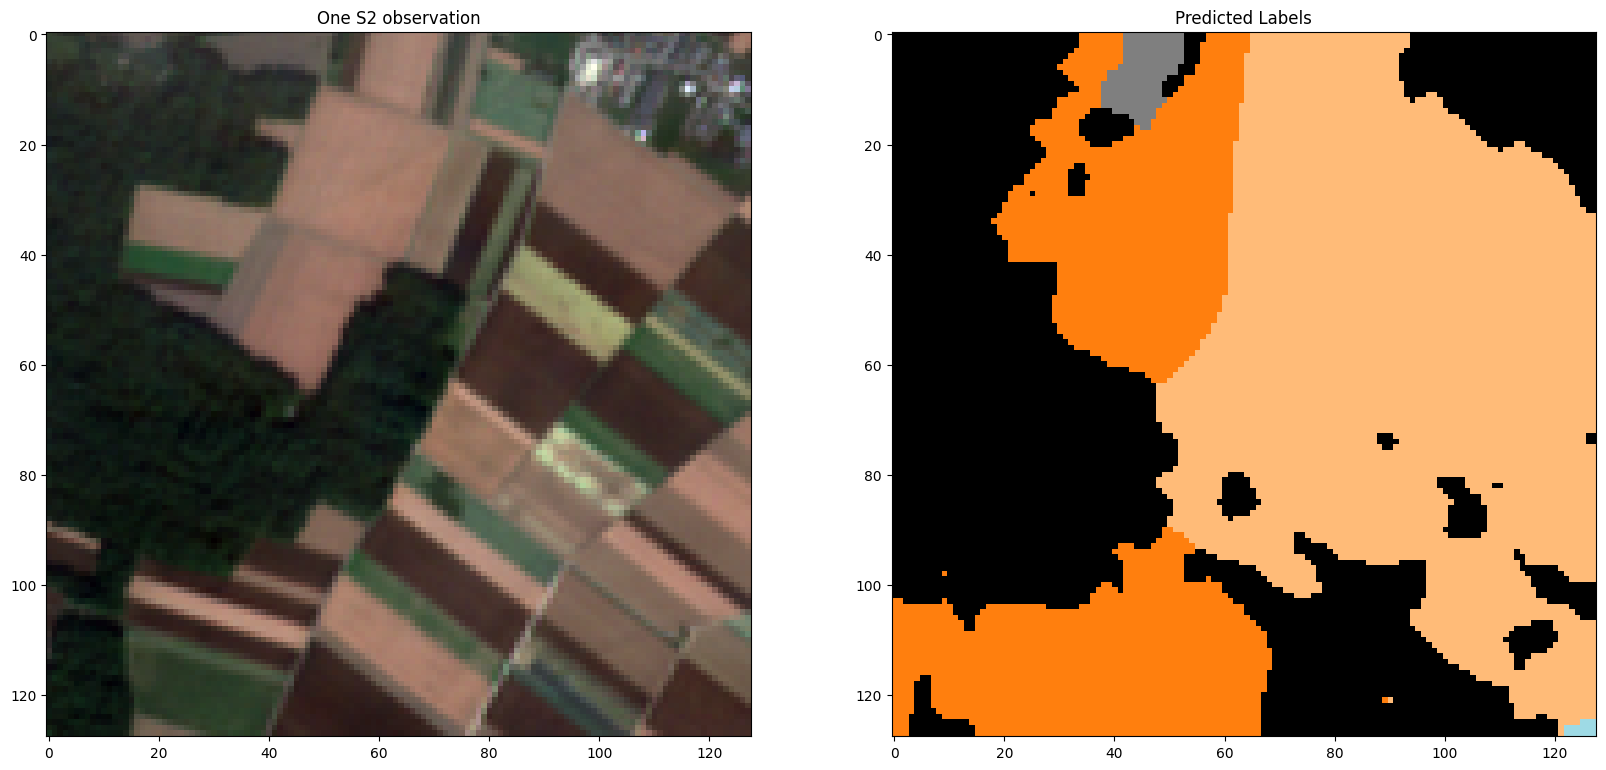

In [50]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(predicted.squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation')
axes[1].set_title('Predicted Labels')

plt.show()